In [1]:
import cebra
from cebra import CEBRA
import cebra.models
import os
from scipy import stats
import tempfile
from pathlib import Path
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import rgb2hex
import pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from scipy.stats import gaussian_kde
import sys
sys.path.append('../../../../')
from dataset_load import data_load
import re
from matplotlib.gridspec import GridSpec

from scipy.stats import chi2
from numpy.linalg import inv

In [2]:
from cebra.models.model import _OffsetModel, ConvolutionalModelMixin
from torch import nn
@cebra.models.register("offset200-model") # --> add that line to register the model!
class Offset200Model(_OffsetModel, ConvolutionalModelMixin):

    def __init__(self, num_neurons, num_units, num_output, normalize=True):
        super().__init__(
            
            nn.Conv1d(num_neurons, num_units, 101),
            nn.GELU(),
            nn.Conv1d(num_units, num_units, 21),
            nn.GELU(),
            nn.Conv1d(num_units, num_units, 21),
            nn.GELU(),
            nn.Conv1d(num_units, num_units, 21),
            nn.GELU(),
            nn.Conv1d(num_units, num_units, 21),
            nn.GELU(),
            nn.Conv1d(num_units, num_output, 20),
            num_input=num_neurons,
            num_output=num_output,
            normalize=normalize,
        )

    # ... and you can also redefine the forward method,
    # as you would for a typical pytorch model

    def get_offset(self) -> cebra.data.datatypes.Offset:
        return cebra.data.Offset(100, 100)

In [3]:
skipdates = ["220818", "220819"]
input_folder = "/sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/"
VICON_FS = 200
variables_to_drop = ["ANIMAL_ID", "CONDITION", "RUN", "DATE", "EVENT", "ECOG_LEFT_fooof_a_knee", "ECOG_RIGHT_fooof_a_knee"]

In [4]:
def animal_to_number(animal_list):
    unique = np.unique(animal_list)
    number_dict = dict()
    number_list = []
    count = 0
    for a in unique:
        number_dict[a] = count
        count+=1
    for a in animal_list:
        number_list.append(number_dict[a])
    return np.asarray(number_list)

In [5]:
data_dict = data_load(input_folder, variables_to_drop, skipdates)

x_pd = data_dict["X_pd"]
y_pd = data_dict["y_pd"]
animals_id_pd = data_dict["animals_id_pd"]

x_h = data_dict["X_h"]
y_h = data_dict["y_h"]
animals_id_h = data_dict["animals_id_h"]

No file found for 230425 NWE00161 02
No file found for 230425 NWE00161 08
No file found for 230425 NWE00160 04
No file found for 230425 NWE00160 03
No file found for 230425 NWE00164 21


In [6]:
loaded_cebra_model = cebra.CEBRA.load("../models/neural_full_pd.pt")

In [7]:
embedding = loaded_cebra_model.transform(x_pd.iloc[:, 36:])

In [8]:
feats_lda = ['ECOG_LEFT_RawHjorth_Complexity', 'ECOG_RIGHT_fft_high gamma',
       'ECOG_LEFT_fft_high beta', 'ECOG_LEFT_RawHjorth_Mobility',
       'ECOG_LEFT_stft_high beta']

feats_cebra = ['ECOG_LEFT_RawHjorth_Complexity',
       'ECOG_RIGHT_bursts_high gamma_amplitude_mean',
       'ECOG_RIGHT_RawHjorth_Complexity', 'ECOG_LEFT_RawHjorth_Activity',
       'ECOG_RIGHT_fft_high gamma', 'ECOG_LEFT_fft_high beta']

In [9]:
X, Y, Z = embedding[:, 0], embedding[:, 1], embedding[:, 2]

NameError: name 'axs' is not defined

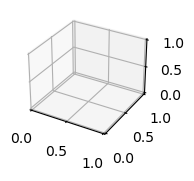

In [10]:
fig = plt.figure(figsize=(12,6))

ax1 = plt.subplot(161, projection='3d')

for i, feat_name in enumerate(feats_cebra):
    title = feat_name.lstrip("ECOG").replace("_", " ")
    if len(title)>20:
        spaces = [m.start() for m in re.finditer(' ', title)]
        split_space = spaces[2]
        title = f"{title[:split_space]} \n {title[split_space+1:]}"
    cebra.plot_embedding(embedding, embedding_labels=x_pd[feat_name], title=title, cmap="coolwarm", vmin=-2, vmax=2, ax=axs[i])
    axs[i].set_zlim(-1, 1)
    axs[i].set_xlim(-1, 1)
    axs[i].set_ylim(-1, 1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_zticks([])
    axs[i].azim = 150
    axs[i].elev = 30

#plt.savefig(f"./CEBRA_train/features_relevance/gait_feat.png")
#plt.close()

In [ ]:


for i, feat_name in enumerate(feats_cebra):
    fig = plt.figure(figsize=(4,4))
    ax1 = plt.subplot(111, projection='3d')
    title = feat_name.lstrip("ECOG")
    if len(title)>20:
        spaces = [m.start() for m in re.finditer(' ', title)]
    cebra.plot_embedding(embedding, embedding_labels=x_pd[feat_name], title="", cmap="coolwarm", vmin=-2, vmax=2, ax=ax1, alpha=0.1, figsize=(10,10))
    ax1.set_zlim(-1, 1)
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax1.azim = 150
    ax1.elev = 30
    ax1.axis("off")

    plt.savefig(f"./feat_dist_3d/{feat_name}.png", transparent=True, dpi=300)
    plt.close()

In [ ]:
feat_name = "ECOG_RIGHT_bursts_high gamma_amplitude_mean"

fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(111, projection='3d')
title = feat_name.lstrip("ECOG")
if len(title)>20:
    spaces = [m.start() for m in re.finditer(' ', title)]
cebra.plot_embedding(embedding, embedding_labels=x_pd[feat_name], title="", cmap="coolwarm", vmin=-1, vmax=1, ax=ax1, alpha=0.5)
ax1.set_zlim(-1, 1)
ax1.set_xlim(1, -1)
ax1.set_ylim(-1, 1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.azim = -120


#plt.savefig(f"cebra_neural_{feat_name}.png", transparent=True, dpi=100)

In [ ]:
feat_name = "ECOG_LEFT_RawHjorth_Complexity"

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot(111, projection='3d')
title = feat_name.lstrip("ECOG")
if len(title)>20:
    spaces = [m.start() for m in re.finditer(' ', title)]
cebra.plot_embedding(embedding, embedding_labels=x_pd[feat_name], title="", cmap="coolwarm", vmin=-1, vmax=1, ax=ax1, alpha=0.5)
ax1.set_zlim(-1, 1)
ax1.set_xlim(1, -1)
ax1.set_ylim(-1, 1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.azim = -120
ax1.axis("off")
plt.savefig(f"cebra_neural_{feat_name}.png", transparent=True, dpi=300)

In [12]:
selected_cebra = ['ECOG_RIGHT_bursts_high gamma_amplitude_mean',
       'ECOG_RIGHT_RawHjorth_Complexity', 'ECOG_LEFT_RawHjorth_Complexity',
       'ECOG_LEFT_fft_high beta', 'ECOG_LEFT_RawHjorth_Activity', 'ECOG_LEFT_Sharpwave_Max_prominence_range_5_30',
       'ECOG_RIGHT_RawHjorth_Mobility',
       'ECOG_LEFT_bursts_high beta_amplitude_max',
       'ECOG_LEFT_bursts_high beta_amplitude_mean',
       'icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high gamma']

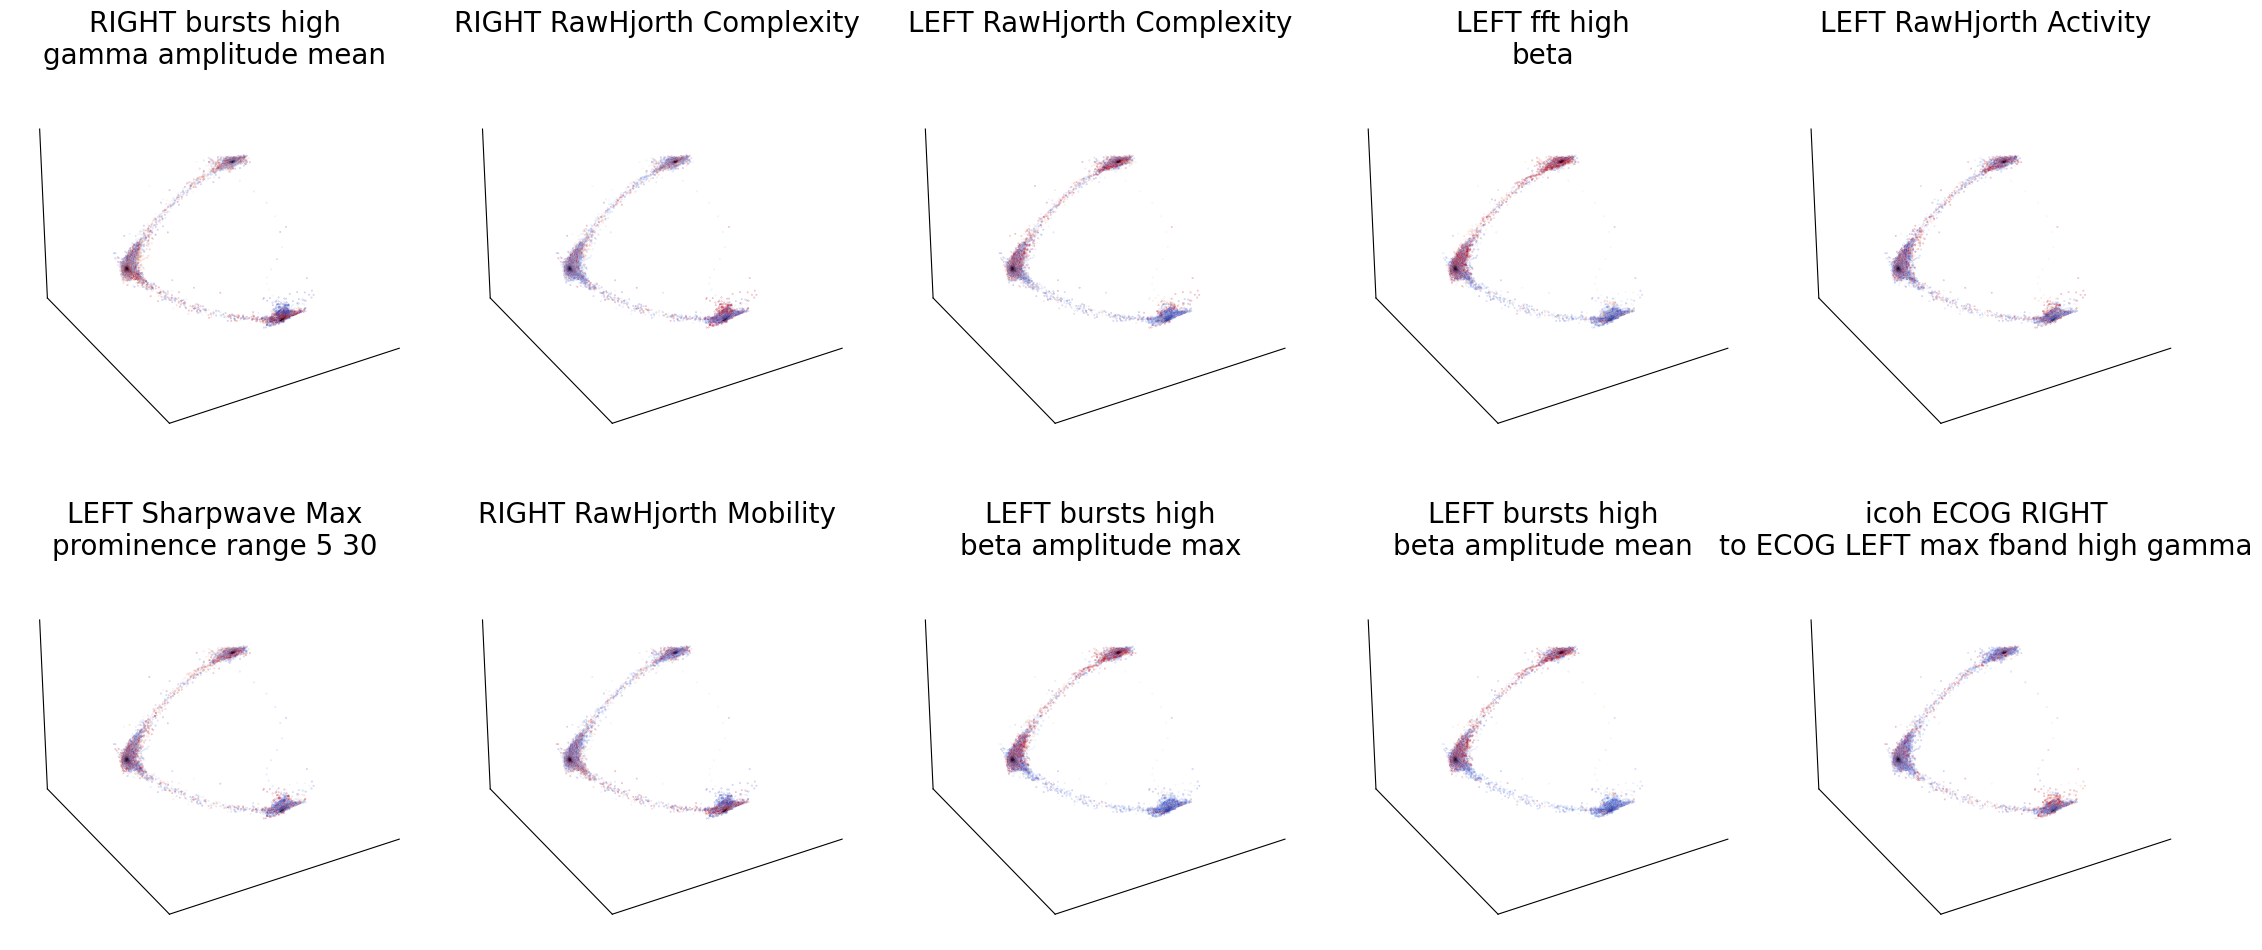

In [16]:
fig = plt.figure(figsize=(30, 10))
axs = []

# Create a 2x5 grid of 3D subplots
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1, projection='3d')
    ax.set_zlim(-1, 1)
    ax.set_xlim(1, -1)
    ax.set_ylim(-1, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.azim = -120
    ax.title.set_fontsize(25)
    ax.xaxis.pane.set_visible(False)
    ax.yaxis.pane.set_visible(False)
    ax.zaxis.pane.set_visible(False)

    axs.append(ax)

for i, feat_name in enumerate(selected_cebra):
    title = feat_name.lstrip("ECOG_")
    title = title.replace("_", " ")
    if len(title)>15:
        title = title.split(" ")
        title = " ".join(title[:3])+ "\n" + " ".join(title[3:])
    cebra.plot_embedding(embedding, embedding_labels=x_pd[feat_name], title="", cmap="coolwarm", vmin=-1, vmax=1, ax=axs[i], alpha=0.5)
    axs[i].set_title(title, fontsize=20)
plt.subplots_adjust(wspace=-0.2, hspace=0.2, top=0.95, bottom=0.05)
plt.savefig(f"cebra_neural_selected.png", transparent=True, dpi=300, bbox_inches='tight')

In [ ]:
selected_cebra = ['ECOG_LEFT_Sharpwave_Max_prominence_range_5_30',
       'ECOG_RIGHT_RawHjorth_Mobility',
       'ECOG_LEFT_bursts_high beta_amplitude_max',
       'ECOG_LEFT_bursts_high beta_amplitude_mean',
       'icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high gamma']

In [ ]:
fig = plt.figure(figsize=(50, 10))
ax1 = plt.subplot(151, projection='3d')
ax2 = plt.subplot(152, projection='3d')
ax3 = plt.subplot(153, projection='3d')
ax4 = plt.subplot(154, projection='3d')
ax5 = plt.subplot(155, projection='3d')
axs = [ax1, ax2, ax3, ax4, ax5]
for i, feat_name in enumerate(selected_cebra):
    title = feat_name.lstrip("ECOG_")
    title = title.replace("_", " ")
    if len(title)>15:
        title = title.split(" ")
        title = " ".join(title[:2])+ "\n" + " ".join(title[2:])
        
    cebra.plot_embedding(embedding, embedding_labels=x_pd[feat_name], title=title, cmap="coolwarm", vmin=-1, vmax=1, ax=axs[i], alpha=0.5)
    axs[i].set_zlim(-1, 1)
    axs[i].set_xlim(1, -1)
    axs[i].set_ylim(-1, 1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_zticks([])
    axs[i].azim = -120
    axs[i].title.set_fontsize(25)
    axs[i].xaxis.pane.set_visible(False)
    axs[i].yaxis.pane.set_visible(False)
    axs[i].zaxis.pane.set_visible(False)
#ax1.axis("off")
plt.savefig(f"cebra_neural_selected_conted.png", transparent=True, dpi=300)